In [ ]:
!pip install antigranular


In [115]:
import antigranular as ag
session = ag.login(<client_id>,<client_secret>, dataset = "Iris Dataset")

Connected to Antigranular server session id: d1fff0f6-e86e-4260-9e02-643205a048ff
Cell magic '%%ag' registered successfully, use `%%ag` in a notebook cell to execute your python code on Antigranular private python server


**Loading the Dataset**

In [116]:
%%ag
from ag_utils import export , load_dataset
import pandas as pd
from op_pandas import PrivateDataFrame


In [117]:
%%ag
x = load_dataset("Iris Dataset")
train_x = x["train_x"]
train_y = x["train_y"]
test_x = x["test_x"]

In [118]:
%%ag
export(train_x.describe(eps=0.1) , 'result')

Total epsilon spent = 0.1000

Setting up exported variable in local environment: result


In [119]:
result

,sepal_length,sepal_width,petal_length,petal_width
count,78.000000,78.000000,78.000000,78.000000
mean,7.900000,2.000000,1.000000,2.500000
std,0.237552,0.791131,1.909051,1.182703
min,4.819109,2.969669,6.332087,0.645779
25%,4.837677,2.933957,2.192958,0.885429
50%,6.691173,2.290216,1.659349,0.896515
75%,5.982968,4.249056,2.569468,2.032130
max,7.129154,2.900269,1.207538,1.670795


**Using Applymap**

In [120]:
%%ag
from typing import Any
# encoding categoricals
def func_(x:str)-> int:
  if x == 'Iris-setosa':
    return 0
  elif x == 'Iris-versicolor':
    return 1
  else: # Iris-virginica
    return 2

train_y_encoded = train_y.applymap(func_ , output_bounds={'species':(0,2)})

In [121]:
%%ag
train_data = train_x.join(train_y_encoded , how="left")
export(train_data.describe(eps=0.5) , 'result')

Total epsilon spent = 0.5000

Setting up exported variable in local environment: result


In [122]:
result

,sepal_length,sepal_width,petal_length,petal_width,species
count,100.000000,100.000000,100.000000,100.000000,100.000000
mean,4.526738,2.486977,5.124667,2.500000,1.405531
std,1.518102,1.079092,2.274950,0.553544,0.744027
min,4.936204,2.094339,1.438538,0.789231,0.819470
25%,5.009556,3.263547,2.347175,1.811475,0.401882
50%,5.724876,2.146421,2.044494,0.472634,0.254012
75%,5.836063,2.846235,6.100310,1.612843,1.131859
max,4.837326,4.058099,5.394570,1.679556,0.892957


**Exploring data using snsql**

In [ ]:
%%ag
import op_snsql

In [124]:
%%ag
privacy = op_snsql.Privacy(epsilon=1.0)
reader = op_snsql.from_df(df=train_y_encoded, privacy=privacy)

In [125]:
%%ag
# get idea about expected privacy_cost that will be spent.
total_cost = reader.get_privacy_cost([
    "SELECT COUNT(species) as setosa from df.table WHERE species == 0",
    "SELECT COUNT(species) as versicolor from df.table WHERE species == 1",
    "SELECT COUNT(species) as virginica from df.table WHERE species == 2"
    ])
export(str(total_cost) , "total_cost")

Setting up exported variable in local environment: total_cost


In [126]:
total_cost # (epsilon , delta)

'(6.0, 3.552713678800501e-15)'

In [127]:
%%ag
# execute returns in the following format -> [[column_names] , [values]]
c0 = reader.execute("SELECT COUNT(species) as setosa from df.table WHERE species == 0")
c1 = reader.execute("SELECT COUNT(species) as versicolor from df.table WHERE species == 1")
c2 = reader.execute("SELECT COUNT(species) as virginica from df.table WHERE species == 2")

export(str([c0,c1,c2]) , 'counts')

Setting up exported variable in local environment: counts


In [128]:
count_data = eval(counts)
col , count = [i[0][0] for i in count_data] , [i[1][0] for i in count_data]
print(f"col = {col} , count = {count}")

col = ['setosa', 'versicolor', 'virginica'] , count = [41, 41, 39]


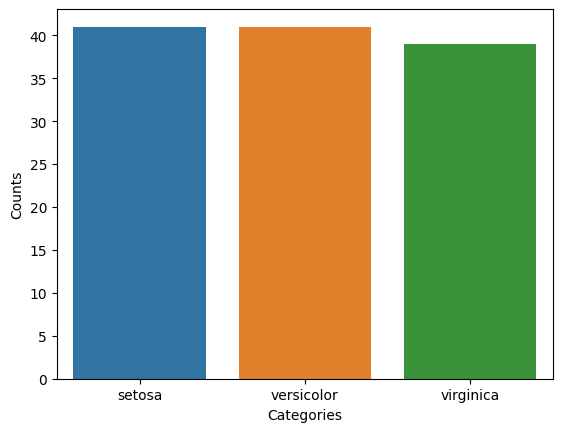

In [129]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(x=col , y=count)
plt.xlabel('Categories')
plt.ylabel('Counts')
plt.show()

**Evaluating correlation of the columns**

In [130]:
%%ag
priv_corr = train_x.corr(eps=7)
export(priv_corr , 'priv_corr')

Setting up exported variable in local environment: priv_corr


<Axes: >

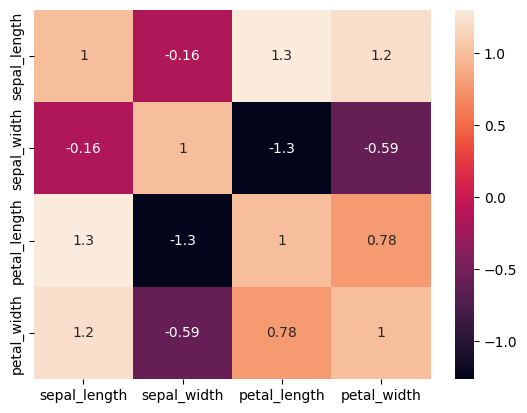

In [131]:
import pandas as pd
result = priv_corr.apply(pd.to_numeric, errors='coerce').astype(float)
sns.heatmap(result , annot = True)

**Implementing RandomForestClassier using diffprivlib**

In [132]:
%%ag
from op_diffprivlib.models import RandomForestClassifier
l_meta, r_meta = [], []
for l,r in train_x.metadata.values():
  l_meta.append(l)
  r_meta.append(r)
bounds = ( l_meta , r_meta ) # ([lower] , [upper])
model = RandomForestClassifier(n_estimators=100, epsilon = 1.0 , random_state=0 , bounds=bounds , classes=['Iris-setosa','Iris-versicolor','Iris-virginica'])

In [133]:
%%ag
model.fit(train_x,train_y)

/usr/local/lib/python3.10/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



In [134]:
%%ag
Y = model.predict(test_x)
export(Y , "output_y")

Setting up exported variable in local environment: output_y


In [135]:
output_y

array(['Iris-versicolor', 'Iris-versicolor', 'Iris-setosa', 'Iris-setosa',
       'Iris-virginica', 'Iris-versicolor', 'Iris-setosa', 'Iris-setosa',
       'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-virginica',
       'Iris-versicolor', 'Iris-virginica', 'Iris-versicolor',
       'Iris-versicolor', 'Iris-virginica', 'Iris-setosa',
       'Iris-versicolor', 'Iris-virginica', 'Iris-versicolor',
       'Iris-versicolor', 'Iris-versicolor', 'Iris-setosa', 'Iris-setosa',
       'Iris-virginica', 'Iris-virginica', 'Iris-setosa',
       'Iris-virginica', 'Iris-virginica'], dtype='<U15')

In [136]:
y_df = pd.DataFrame(output_y)
result = session.submit_predictions(y_df)

In [137]:
# Privacy budget spent
session.privacy_odometer()

{'total_epsilon_used': 14.6, 'total_delta_used': 4.6629367034256575e-15}

In [142]:
print(result)

{'score': {'leaderboard': 0.0952889403582408, 'logs': {'BIN_ACC': 0.723479823408934}}}
